# Data Cleaning, EDA and Models
This notebook imports collected data from my selected subreddits and performs cleaning and EDA. Intital Models are built and tested.

## Imports

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer

## Read in the data

~~Something wetn wrong during data collection so I've added a subreddit column to use as target.~~

In [3]:
unresolved = pd.read_csv('../data/unresolved.csv').drop(columns='Unnamed: 0')
#unresolved['subreddit'] = 'unresolved'
unresolved.head(2)

,author,awarders,created_utc,selftext,subreddit,title
0,TheBonesOfAutumn,[],1643236773,"On April 8th, 1981, 19-year-old David Huff dec...",UnresolvedMysteries,"In April of 1981, the body of 23-year-old Shar..."
1,Skoodilypoop666,[],1643233541,"In the fall of 2021, The small town of London ...",UnresolvedMysteries,“Whodunnit” the murder of 62 year old Bryan Mc...


In [4]:
unsolved = pd.read_csv('../data/unsolved.csv').drop(columns='Unnamed: 0')
#unsolved['subreddit'] = 'unsolved'
unsolved.head(2)

,author,awarders,created_utc,selftext,subreddit,title
0,amkakis,[],1643239264,NaN,UnsolvedMysteries,An 18 year old leaves home to retrieve a purse...
1,Once_a_TQ,[],1643227462,NaN,UnsolvedMysteries,Search continues for retired Cape Breton veter...


In [5]:
unsolved['selftext'].isna().sum()

1090

In [6]:
unsolved['awarders'].value_counts()

[]    1099
Name: awarders, dtype: int64

In [7]:
unresolved['awarders'].value_counts()

[]    1009
Name: awarders, dtype: int64

**'selftext' empty in UnsolvedMysteries posts, will focus on title only for now.**

## Data Cleaning

### Concat/Merge Data
Drop 'selftext', 'awarders' columns from both datasets and merge/concat them together

In [8]:
unsolved = unsolved.drop(columns=['awarders', 'selftext'])
unresolved = unresolved.drop(columns=['awarders', 'selftext'])

In [14]:
data = pd.concat([unsolved, unresolved], ignore_index=True)
data.head()

,author,created_utc,subreddit,title
0,amkakis,1643239264,UnsolvedMysteries,An 18 year old leaves home to retrieve a purse...
1,Once_a_TQ,1643227462,UnsolvedMysteries,Search continues for retired Cape Breton veter...
2,lexx999,1643224623,UnsolvedMysteries,"On December 31 2021, around 01:50, every trace..."
3,lexx999,1643224227,UnsolvedMysteries,"On December 31 2021, around 01:50, every trace..."
4,010010100100011001,1643216812,UnsolvedMysteries,McMartin Preschool Satanic abuse: 20-minute pr...


In [10]:
data.shape

(2108, 4)

### Drop duplicates

In [11]:
data.duplicated().sum()

1

In [12]:
data = data.drop_duplicates()

### Binarize target variable
1 == UnresolvedMysteries <br>
0 == UnsolvedMysteries

In [35]:
data['subreddit'] = data['subreddit'].map(
    {
        'UnresolvedMysteries': 1,
        'UnsolvedMysteries': 0,
    }
)
data.head(2)

,author,created_utc,subreddit,title,title_len,title_count
0,amkakis,1643239264,0,An 18 year old leaves home to retrieve a purse...,107,21
1,Once_a_TQ,1643227462,0,Search continues for retired Cape Breton veter...,67,10


## EDA
### Let's add a length and word count based on title and examine distributions.


In [36]:
data['title_len'] = data['title'].str.len()

In [37]:
data['title_count'] = data['title'].map(lambda x: len(x.split()))

### **Good place to add some kind of sentiment score**

In [38]:
# Sanity check
data.head(2)

,author,created_utc,subreddit,title,title_len,title_count
0,amkakis,1643239264,0,An 18 year old leaves home to retrieve a purse...,107,21
1,Once_a_TQ,1643227462,0,Search continues for retired Cape Breton veter...,67,10


### Full data pairplot

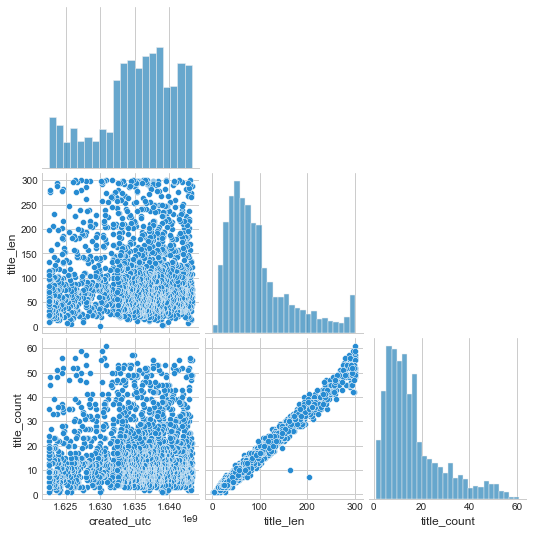

In [41]:
# With help from: https://github.com/matplotlib/ipympl/issues/25
plt.style.use(['seaborn-whitegrid'])
sns.pairplot(data.drop(columns='subreddit'), corner=True);

There are two outliers where title length doesn't align with title count. Nothing alarming though.

Title length and title count both appear normally distributed with right tail skew, which is expected: Mostly normal posts with some having longer titles.

Let's run two more pairplots, one for each subreddit.

### UnresolvedMysteries pairplot

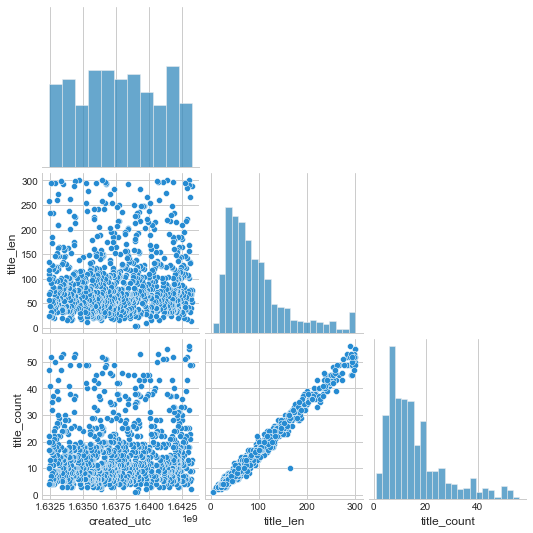

In [43]:
# With help from: https://github.com/matplotlib/ipympl/issues/25
plt.style.use(['seaborn-whitegrid'])
sns.pairplot(data[data['subreddit'] == 1].drop(columns='subreddit'), corner=True);

### UnsolvedMysteries pairplot

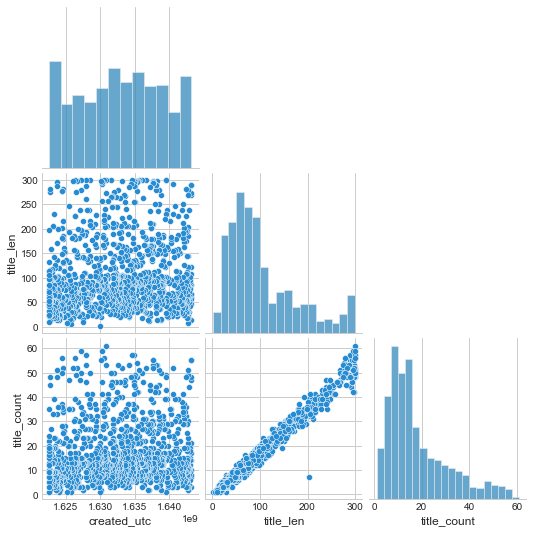

In [44]:
# With help from: https://github.com/matplotlib/ipympl/issues/25
plt.style.use(['seaborn-whitegrid'])
sns.pairplot(data[data['subreddit'] == 0].drop(columns='subreddit'), corner=True);

### Summary Statistics

In [45]:
data.describe()

,created_utc,subreddit,title_len,title_count
count,2.108000e+03,2108.000000,2108.000000,2108.000000
mean,1.635179e+09,0.478653,99.303605,16.838235
std,5.429183e+06,0.499663,69.132175,12.282118
min,1.622510e+09,0.000000,1.000000,1.000000
25%,1.632452e+09,0.000000,50.000000,8.000000
50%,1.635985e+09,0.000000,79.000000,13.000000
75%,1.639211e+09,1.000000,126.000000,22.000000
max,1.643239e+09,1.000000,301.000000,61.000000


### EDA notes

The data seems to be fairly balanced and the numerical predictors are normally distributed. It appears this is a good dataset to use NLP and attempt to correctly classify the subreddit based on the words in the title of each post.

## Preprocessing and Models

### Train-Test split
Start with 'title' only to build our baseline and first models

In [46]:
X = data['title']
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1331)

### Baseline model
Count Vectorizer and Dummy Classifier

In [47]:
cv = CountVectorizer()
X_train_transformed = cv.fit_transform(X_train)
X_test_transfomed = cv.transform(X_test)

In [48]:
null_model = DummyClassifier()
null_model.fit(X_train_transformed, y_train)
null_model.score(X_test_transfomed, y_test)

0.5218216318785579

In [50]:
y_test.value_counts(normalize=True)

0    0.521822
1    0.478178
Name: subreddit, dtype: float64

### Model function
A function to build and score models that can be used throughout the rest of the notebook.